In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                                      | 0/50000 [00:00<?, ?it/s]

  9%|██████████▍                                                                                                             | 4335/50000 [00:00<00:01, 43347.87it/s]

 17%|████████████████████▊                                                                                                   | 8670/50000 [00:00<00:00, 43224.39it/s]

 26%|███████████████████████████████                                                                                        | 13067/50000 [00:00<00:00, 43563.58it/s]

 35%|█████████████████████████████████████████▌                                                                             | 17487/50000 [00:00<00:00, 43810.69it/s]

 44%|████████████████████████████████████████████████████                                                                   | 21889/50000 [00:00<00:00, 43883.34it/s]

 53%|██████████████████████████████████████████████████████████████▌                                                        | 26278/50000 [00:00<00:00, 43412.01it/s]

 61%|█████████████████████████████████████████████████████████████████████████                                              | 30694/50000 [00:00<00:00, 43653.65it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▍                                   | 35061/50000 [00:00<00:00, 43588.51it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████▊                         | 39439/50000 [00:00<00:00, 43646.61it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 43805/50000 [00:01<00:00, 43145.25it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 48195/50000 [00:01<00:00, 43372.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43490.69it/s]

Files already downloaded and verified


  0%|                                                                                                                                      | 0/10000 [00:00<?, ?it/s]

 40%|████████████████████████████████████████████████▏                                                                       | 4017/10000 [00:00<00:00, 40158.93it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8371/10000 [00:00<00:00, 42142.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 42057.77it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 yk4jbpb0


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                        | 0/313 [00:00<?, ?it/s]

  0%|▍                                                                                                                               | 1/313 [00:00<05:06,  1.02it/s]

  1%|▊                                                                                                                               | 2/313 [00:01<02:28,  2.09it/s]

  1%|█▏                                                                                                                              | 3/313 [00:01<01:38,  3.15it/s]

  1%|█▋                                                                                                                              | 4/313 [00:01<01:14,  4.12it/s]

  2%|██                                                                                                                              | 5/313 [00:01<01:01,  4.98it/s]

  2%|██▍                                                                                                                             | 6/313 [00:01<00:54,  5.68it/s]

  2%|██▊                                                                                                                             | 7/313 [00:01<00:48,  6.25it/s]

  3%|███▎                                                                                                                            | 8/313 [00:01<00:45,  6.69it/s]

  3%|███▋                                                                                                                            | 9/313 [00:01<00:43,  7.01it/s]

  3%|████                                                                                                                           | 10/313 [00:02<00:41,  7.25it/s]

  4%|████▍                                                                                                                          | 11/313 [00:02<00:40,  7.42it/s]

  4%|████▊                                                                                                                          | 12/313 [00:02<00:39,  7.55it/s]

  4%|█████▎                                                                                                                         | 13/313 [00:02<00:39,  7.64it/s]

  4%|█████▋                                                                                                                         | 14/313 [00:02<00:38,  7.71it/s]

  5%|██████                                                                                                                         | 15/313 [00:02<00:38,  7.76it/s]

  5%|██████▍                                                                                                                        | 16/313 [00:02<00:38,  7.80it/s]

  5%|██████▉                                                                                                                        | 17/313 [00:03<00:37,  7.82it/s]

  6%|███████▎                                                                                                                       | 18/313 [00:03<00:37,  7.84it/s]

  6%|███████▋                                                                                                                       | 19/313 [00:03<00:37,  7.84it/s]

  6%|████████                                                                                                                       | 20/313 [00:03<00:37,  7.84it/s]

  7%|████████▌                                                                                                                      | 21/313 [00:03<00:37,  7.85it/s]

  7%|████████▉                                                                                                                      | 22/313 [00:03<00:37,  7.86it/s]

  7%|█████████▎                                                                                                                     | 23/313 [00:03<00:36,  7.86it/s]

  8%|█████████▋                                                                                                                     | 24/313 [00:03<00:36,  7.85it/s]

  8%|██████████▏                                                                                                                    | 25/313 [00:04<00:36,  7.86it/s]

  8%|██████████▌                                                                                                                    | 26/313 [00:04<00:36,  7.86it/s]

  9%|██████████▉                                                                                                                    | 27/313 [00:04<00:36,  7.86it/s]

  9%|███████████▎                                                                                                                   | 28/313 [00:04<00:36,  7.86it/s]

  9%|███████████▊                                                                                                                   | 29/313 [00:04<00:36,  7.87it/s]

 10%|████████████▏                                                                                                                  | 30/313 [00:04<00:36,  7.86it/s]

 10%|████████████▌                                                                                                                  | 31/313 [00:04<00:35,  7.85it/s]

 10%|████████████▉                                                                                                                  | 32/313 [00:04<00:35,  7.86it/s]

 11%|█████████████▍                                                                                                                 | 33/313 [00:05<00:35,  7.86it/s]

 11%|█████████████▊                                                                                                                 | 34/313 [00:05<00:35,  7.86it/s]

 11%|██████████████▏                                                                                                                | 35/313 [00:05<00:35,  7.86it/s]

 12%|██████████████▌                                                                                                                | 36/313 [00:05<00:35,  7.86it/s]

 12%|███████████████                                                                                                                | 37/313 [00:05<00:35,  7.86it/s]

 12%|███████████████▍                                                                                                               | 38/313 [00:05<00:34,  7.86it/s]

 12%|███████████████▊                                                                                                               | 39/313 [00:05<00:34,  7.87it/s]

 13%|████████████████▏                                                                                                              | 40/313 [00:05<00:34,  7.87it/s]

 13%|████████████████▋                                                                                                              | 41/313 [00:06<00:34,  7.87it/s]

 13%|█████████████████                                                                                                              | 42/313 [00:06<00:34,  7.87it/s]

 14%|█████████████████▍                                                                                                             | 43/313 [00:06<00:34,  7.87it/s]

 14%|█████████████████▊                                                                                                             | 44/313 [00:06<00:34,  7.87it/s]

 14%|██████████████████▎                                                                                                            | 45/313 [00:06<00:34,  7.87it/s]

 15%|██████████████████▋                                                                                                            | 46/313 [00:06<00:33,  7.88it/s]

 15%|███████████████████                                                                                                            | 47/313 [00:06<00:33,  7.87it/s]

 15%|███████████████████▍                                                                                                           | 48/313 [00:06<00:33,  7.87it/s]

 16%|███████████████████▉                                                                                                           | 49/313 [00:07<00:33,  7.87it/s]

 16%|████████████████████▎                                                                                                          | 50/313 [00:07<00:33,  7.87it/s]

 16%|████████████████████▋                                                                                                          | 51/313 [00:07<00:33,  7.87it/s]

 17%|█████████████████████                                                                                                          | 52/313 [00:07<00:33,  7.87it/s]

 17%|█████████████████████▌                                                                                                         | 53/313 [00:07<00:33,  7.86it/s]

 17%|█████████████████████▉                                                                                                         | 54/313 [00:07<00:32,  7.86it/s]

 18%|██████████████████████▎                                                                                                        | 55/313 [00:07<00:32,  7.87it/s]

 18%|██████████████████████▋                                                                                                        | 56/313 [00:07<00:32,  7.87it/s]

 18%|███████████████████████▏                                                                                                       | 57/313 [00:08<00:32,  7.87it/s]

 19%|███████████████████████▌                                                                                                       | 58/313 [00:08<00:32,  7.87it/s]

 19%|███████████████████████▉                                                                                                       | 59/313 [00:08<00:32,  7.88it/s]

 19%|████████████████████████▎                                                                                                      | 60/313 [00:08<00:32,  7.87it/s]

 19%|████████████████████████▊                                                                                                      | 61/313 [00:08<00:32,  7.87it/s]

 20%|█████████████████████████▏                                                                                                     | 62/313 [00:08<00:31,  7.87it/s]

 20%|█████████████████████████▌                                                                                                     | 63/313 [00:08<00:31,  7.87it/s]

 20%|█████████████████████████▉                                                                                                     | 64/313 [00:08<00:31,  7.86it/s]

 21%|██████████████████████████▎                                                                                                    | 65/313 [00:09<00:31,  7.86it/s]

 21%|██████████████████████████▊                                                                                                    | 66/313 [00:09<00:31,  7.87it/s]

 21%|███████████████████████████▏                                                                                                   | 67/313 [00:09<00:31,  7.87it/s]

 22%|███████████████████████████▌                                                                                                   | 68/313 [00:09<00:31,  7.87it/s]

 22%|███████████████████████████▉                                                                                                   | 69/313 [00:09<00:31,  7.87it/s]

 22%|████████████████████████████▍                                                                                                  | 70/313 [00:09<00:30,  7.86it/s]

 23%|████████████████████████████▊                                                                                                  | 71/313 [00:09<00:30,  7.86it/s]

 23%|█████████████████████████████▏                                                                                                 | 72/313 [00:10<00:30,  7.86it/s]

 23%|█████████████████████████████▌                                                                                                 | 73/313 [00:10<00:30,  7.85it/s]

 24%|██████████████████████████████                                                                                                 | 74/313 [00:10<00:30,  7.86it/s]

 24%|██████████████████████████████▍                                                                                                | 75/313 [00:10<00:30,  7.86it/s]

 24%|██████████████████████████████▊                                                                                                | 76/313 [00:10<00:30,  7.85it/s]

 25%|███████████████████████████████▏                                                                                               | 77/313 [00:10<00:30,  7.86it/s]

 25%|███████████████████████████████▋                                                                                               | 78/313 [00:10<00:29,  7.86it/s]

 25%|████████████████████████████████                                                                                               | 79/313 [00:10<00:29,  7.86it/s]

 26%|████████████████████████████████▍                                                                                              | 80/313 [00:11<00:29,  7.87it/s]

 26%|████████████████████████████████▊                                                                                              | 81/313 [00:11<00:29,  7.86it/s]

 26%|█████████████████████████████████▎                                                                                             | 82/313 [00:11<00:29,  7.87it/s]

 27%|█████████████████████████████████▋                                                                                             | 83/313 [00:11<00:29,  7.87it/s]

 27%|██████████████████████████████████                                                                                             | 84/313 [00:11<00:29,  7.88it/s]

 27%|██████████████████████████████████▍                                                                                            | 85/313 [00:11<00:28,  7.88it/s]

 27%|██████████████████████████████████▉                                                                                            | 86/313 [00:11<00:28,  7.88it/s]

 28%|███████████████████████████████████▎                                                                                           | 87/313 [00:11<00:28,  7.86it/s]

 28%|███████████████████████████████████▋                                                                                           | 88/313 [00:12<00:28,  7.86it/s]

 28%|████████████████████████████████████                                                                                           | 89/313 [00:12<00:28,  7.87it/s]

 29%|████████████████████████████████████▌                                                                                          | 90/313 [00:12<00:28,  7.88it/s]

 29%|████████████████████████████████████▉                                                                                          | 91/313 [00:12<00:28,  7.88it/s]

 29%|█████████████████████████████████████▎                                                                                         | 92/313 [00:12<00:28,  7.87it/s]

 30%|█████████████████████████████████████▋                                                                                         | 93/313 [00:12<00:27,  7.87it/s]

 30%|██████████████████████████████████████▏                                                                                        | 94/313 [00:12<00:27,  7.87it/s]

 30%|██████████████████████████████████████▌                                                                                        | 95/313 [00:12<00:27,  7.87it/s]

 31%|██████████████████████████████████████▉                                                                                        | 96/313 [00:13<00:27,  7.87it/s]

 31%|███████████████████████████████████████▎                                                                                       | 97/313 [00:13<00:27,  7.87it/s]

 31%|███████████████████████████████████████▊                                                                                       | 98/313 [00:13<00:27,  7.87it/s]

 32%|████████████████████████████████████████▏                                                                                      | 99/313 [00:13<00:27,  7.87it/s]

 32%|████████████████████████████████████████▎                                                                                     | 100/313 [00:13<00:27,  7.87it/s]

 32%|████████████████████████████████████████▋                                                                                     | 101/313 [00:13<00:27,  7.85it/s]

 33%|█████████████████████████████████████████                                                                                     | 102/313 [00:13<00:26,  7.85it/s]

 33%|█████████████████████████████████████████▍                                                                                    | 103/313 [00:13<00:26,  7.86it/s]

 33%|█████████████████████████████████████████▊                                                                                    | 104/313 [00:14<00:26,  7.86it/s]

 34%|██████████████████████████████████████████▎                                                                                   | 105/313 [00:14<00:26,  7.86it/s]

 34%|██████████████████████████████████████████▋                                                                                   | 106/313 [00:14<00:26,  7.86it/s]

 34%|███████████████████████████████████████████                                                                                   | 107/313 [00:14<00:26,  7.86it/s]

 35%|███████████████████████████████████████████▍                                                                                  | 108/313 [00:14<00:26,  7.87it/s]

 35%|███████████████████████████████████████████▉                                                                                  | 109/313 [00:14<00:25,  7.87it/s]

 35%|████████████████████████████████████████████▎                                                                                 | 110/313 [00:14<00:25,  7.87it/s]

 35%|████████████████████████████████████████████▋                                                                                 | 111/313 [00:14<00:25,  7.87it/s]

 36%|█████████████████████████████████████████████                                                                                 | 112/313 [00:15<00:25,  7.87it/s]

 36%|█████████████████████████████████████████████▍                                                                                | 113/313 [00:15<00:25,  7.87it/s]

 36%|█████████████████████████████████████████████▉                                                                                | 114/313 [00:15<00:25,  7.87it/s]

 37%|██████████████████████████████████████████████▎                                                                               | 115/313 [00:15<00:25,  7.86it/s]

 37%|██████████████████████████████████████████████▋                                                                               | 116/313 [00:15<00:25,  7.85it/s]

 37%|███████████████████████████████████████████████                                                                               | 117/313 [00:15<00:24,  7.85it/s]

 38%|███████████████████████████████████████████████▌                                                                              | 118/313 [00:15<00:24,  7.86it/s]

 38%|███████████████████████████████████████████████▉                                                                              | 119/313 [00:15<00:24,  7.86it/s]

 38%|████████████████████████████████████████████████▎                                                                             | 120/313 [00:16<00:24,  7.87it/s]

 39%|████████████████████████████████████████████████▋                                                                             | 121/313 [00:16<00:24,  7.86it/s]

 39%|█████████████████████████████████████████████████                                                                             | 122/313 [00:16<00:24,  7.87it/s]

 39%|█████████████████████████████████████████████████▌                                                                            | 123/313 [00:16<00:24,  7.87it/s]

 40%|█████████████████████████████████████████████████▉                                                                            | 124/313 [00:16<00:24,  7.87it/s]

 40%|██████████████████████████████████████████████████▎                                                                           | 125/313 [00:16<00:23,  7.87it/s]

 40%|██████████████████████████████████████████████████▋                                                                           | 126/313 [00:16<00:23,  7.87it/s]

 41%|███████████████████████████████████████████████████                                                                           | 127/313 [00:16<00:23,  7.88it/s]

 41%|███████████████████████████████████████████████████▌                                                                          | 128/313 [00:17<00:23,  7.87it/s]

 41%|███████████████████████████████████████████████████▉                                                                          | 129/313 [00:17<00:23,  7.87it/s]

 42%|████████████████████████████████████████████████████▎                                                                         | 130/313 [00:17<00:23,  7.88it/s]

 42%|████████████████████████████████████████████████████▋                                                                         | 131/313 [00:17<00:23,  7.88it/s]

 42%|█████████████████████████████████████████████████████▏                                                                        | 132/313 [00:17<00:22,  7.87it/s]

 42%|█████████████████████████████████████████████████████▌                                                                        | 133/313 [00:17<00:22,  7.88it/s]

 43%|█████████████████████████████████████████████████████▉                                                                        | 134/313 [00:17<00:22,  7.87it/s]

 43%|██████████████████████████████████████████████████████▎                                                                       | 135/313 [00:18<00:22,  7.87it/s]

 43%|██████████████████████████████████████████████████████▋                                                                       | 136/313 [00:18<00:22,  7.87it/s]

 44%|███████████████████████████████████████████████████████▏                                                                      | 137/313 [00:18<00:22,  7.87it/s]

 44%|███████████████████████████████████████████████████████▌                                                                      | 138/313 [00:18<00:22,  7.87it/s]

 44%|███████████████████████████████████████████████████████▉                                                                      | 139/313 [00:18<00:22,  7.87it/s]

 45%|████████████████████████████████████████████████████████▎                                                                     | 140/313 [00:18<00:21,  7.87it/s]

 45%|████████████████████████████████████████████████████████▊                                                                     | 141/313 [00:18<00:21,  7.88it/s]

 45%|█████████████████████████████████████████████████████████▏                                                                    | 142/313 [00:18<00:21,  7.87it/s]

 46%|█████████████████████████████████████████████████████████▌                                                                    | 143/313 [00:19<00:21,  7.87it/s]

 46%|█████████████████████████████████████████████████████████▉                                                                    | 144/313 [00:19<00:21,  7.88it/s]

 46%|██████████████████████████████████████████████████████████▎                                                                   | 145/313 [00:19<00:21,  7.88it/s]

 47%|██████████████████████████████████████████████████████████▊                                                                   | 146/313 [00:19<00:21,  7.88it/s]

 47%|███████████████████████████████████████████████████████████▏                                                                  | 147/313 [00:19<00:21,  7.88it/s]

 47%|███████████████████████████████████████████████████████████▌                                                                  | 148/313 [00:19<00:20,  7.87it/s]

 48%|███████████████████████████████████████████████████████████▉                                                                  | 149/313 [00:19<00:20,  7.87it/s]

 48%|████████████████████████████████████████████████████████████▍                                                                 | 150/313 [00:19<00:20,  7.88it/s]

 48%|████████████████████████████████████████████████████████████▊                                                                 | 151/313 [00:20<00:20,  7.88it/s]

 49%|█████████████████████████████████████████████████████████████▏                                                                | 152/313 [00:20<00:20,  7.87it/s]

 49%|█████████████████████████████████████████████████████████████▌                                                                | 153/313 [00:20<00:20,  7.87it/s]

 49%|█████████████████████████████████████████████████████████████▉                                                                | 154/313 [00:20<00:20,  7.86it/s]

 50%|██████████████████████████████████████████████████████████████▍                                                               | 155/313 [00:20<00:20,  7.87it/s]

 50%|██████████████████████████████████████████████████████████████▊                                                               | 156/313 [00:20<00:19,  7.87it/s]

 50%|███████████████████████████████████████████████████████████████▏                                                              | 157/313 [00:20<00:19,  7.87it/s]

 50%|███████████████████████████████████████████████████████████████▌                                                              | 158/313 [00:20<00:19,  7.87it/s]

 51%|████████████████████████████████████████████████████████████████                                                              | 159/313 [00:21<00:19,  7.87it/s]

 51%|████████████████████████████████████████████████████████████████▍                                                             | 160/313 [00:21<00:19,  7.87it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                             | 161/313 [00:21<00:19,  7.87it/s]

 52%|█████████████████████████████████████████████████████████████████▏                                                            | 162/313 [00:21<00:19,  7.87it/s]

 52%|█████████████████████████████████████████████████████████████████▌                                                            | 163/313 [00:21<00:19,  7.87it/s]

 52%|██████████████████████████████████████████████████████████████████                                                            | 164/313 [00:21<00:18,  7.87it/s]

 53%|██████████████████████████████████████████████████████████████████▍                                                           | 165/313 [00:21<00:18,  7.87it/s]

 53%|██████████████████████████████████████████████████████████████████▊                                                           | 166/313 [00:21<00:18,  7.87it/s]

 53%|███████████████████████████████████████████████████████████████████▏                                                          | 167/313 [00:22<00:18,  7.87it/s]

 54%|███████████████████████████████████████████████████████████████████▋                                                          | 168/313 [00:22<00:18,  7.87it/s]

 54%|████████████████████████████████████████████████████████████████████                                                          | 169/313 [00:22<00:18,  7.87it/s]

 54%|████████████████████████████████████████████████████████████████████▍                                                         | 170/313 [00:22<00:18,  7.88it/s]

 55%|████████████████████████████████████████████████████████████████████▊                                                         | 171/313 [00:22<00:18,  7.87it/s]

 55%|█████████████████████████████████████████████████████████████████████▏                                                        | 172/313 [00:22<00:17,  7.87it/s]

 55%|█████████████████████████████████████████████████████████████████████▋                                                        | 173/313 [00:22<00:17,  7.87it/s]

 56%|██████████████████████████████████████████████████████████████████████                                                        | 174/313 [00:22<00:17,  7.86it/s]

 56%|██████████████████████████████████████████████████████████████████████▍                                                       | 175/313 [00:23<00:17,  7.87it/s]

 56%|██████████████████████████████████████████████████████████████████████▊                                                       | 176/313 [00:23<00:17,  7.87it/s]

 57%|███████████████████████████████████████████████████████████████████████▎                                                      | 177/313 [00:23<00:17,  7.87it/s]

 57%|███████████████████████████████████████████████████████████████████████▋                                                      | 178/313 [00:23<00:17,  7.87it/s]

 57%|████████████████████████████████████████████████████████████████████████                                                      | 179/313 [00:23<00:17,  7.87it/s]

 58%|████████████████████████████████████████████████████████████████████████▍                                                     | 180/313 [00:23<00:16,  7.87it/s]

 58%|████████████████████████████████████████████████████████████████████████▊                                                     | 181/313 [00:23<00:16,  7.87it/s]

 58%|█████████████████████████████████████████████████████████████████████████▎                                                    | 182/313 [00:23<00:16,  7.87it/s]

 58%|█████████████████████████████████████████████████████████████████████████▋                                                    | 183/313 [00:24<00:16,  7.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████                                                    | 184/313 [00:24<00:16,  7.87it/s]

 59%|██████████████████████████████████████████████████████████████████████████▍                                                   | 185/313 [00:24<00:16,  7.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████▉                                                   | 186/313 [00:24<00:16,  7.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████▎                                                  | 187/313 [00:24<00:16,  7.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████▋                                                  | 188/313 [00:24<00:15,  7.87it/s]

 60%|████████████████████████████████████████████████████████████████████████████                                                  | 189/313 [00:24<00:15,  7.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████▍                                                 | 190/313 [00:25<00:15,  7.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████▉                                                 | 191/313 [00:25<00:15,  7.87it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▎                                                | 192/313 [00:25<00:15,  7.86it/s]

 62%|█████████████████████████████████████████████████████████████████████████████▋                                                | 193/313 [00:25<00:15,  7.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████                                                | 194/313 [00:25<00:15,  7.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▍                                               | 195/313 [00:25<00:14,  7.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████▉                                               | 196/313 [00:25<00:14,  7.86it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▎                                              | 197/313 [00:25<00:14,  7.87it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▋                                              | 198/313 [00:26<00:14,  7.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████                                              | 199/313 [00:26<00:14,  7.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▌                                             | 200/313 [00:26<00:14,  7.85it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▉                                             | 201/313 [00:26<00:14,  7.85it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▎                                            | 202/313 [00:26<00:14,  7.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▋                                            | 203/313 [00:26<00:13,  7.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████                                            | 204/313 [00:26<00:13,  7.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▌                                           | 205/313 [00:26<00:13,  7.87it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████▉                                           | 206/313 [00:27<00:13,  7.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▎                                          | 207/313 [00:27<00:13,  7.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▋                                          | 208/313 [00:27<00:13,  7.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▏                                         | 209/313 [00:27<00:13,  7.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▌                                         | 210/313 [00:27<00:13,  7.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▉                                         | 211/313 [00:27<00:12,  7.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▎                                        | 212/313 [00:27<00:12,  7.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▋                                        | 213/313 [00:27<00:12,  7.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▏                                       | 214/313 [00:28<00:12,  7.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▌                                       | 215/313 [00:28<00:12,  7.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████▉                                       | 216/313 [00:28<00:12,  7.86it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▎                                      | 217/313 [00:28<00:12,  7.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████▊                                      | 218/313 [00:28<00:12,  7.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▏                                     | 219/313 [00:28<00:11,  7.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                     | 220/313 [00:28<00:11,  7.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████▉                                     | 221/313 [00:28<00:11,  7.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▎                                    | 222/313 [00:29<00:11,  7.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                    | 223/313 [00:29<00:11,  7.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▏                                   | 224/313 [00:29<00:11,  7.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▌                                   | 225/313 [00:29<00:11,  7.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▉                                   | 226/313 [00:29<00:11,  7.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                  | 227/313 [00:29<00:10,  7.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████▊                                  | 228/313 [00:29<00:10,  7.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 229/313 [00:29<00:10,  7.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 230/313 [00:30<00:10,  7.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 231/313 [00:30<00:10,  7.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                | 232/313 [00:30<00:10,  7.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                | 233/313 [00:30<00:10,  7.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▏                               | 234/313 [00:30<00:10,  7.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▌                               | 235/313 [00:30<00:09,  7.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                               | 236/313 [00:30<00:09,  7.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                              | 237/313 [00:30<00:09,  7.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▊                              | 238/313 [00:31<00:09,  7.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 239/313 [00:31<00:09,  7.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 240/313 [00:31<00:09,  7.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████                             | 241/313 [00:31<00:09,  7.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 242/313 [00:31<00:09,  7.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 243/313 [00:31<00:08,  7.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 244/313 [00:31<00:08,  7.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 245/313 [00:31<00:08,  7.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████                           | 246/313 [00:32<00:08,  7.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 247/313 [00:32<00:08,  7.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 248/313 [00:32<00:08,  7.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 249/313 [00:32<00:08,  7.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 250/313 [00:32<00:08,  7.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                         | 251/313 [00:32<00:07,  7.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 252/313 [00:32<00:07,  7.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 253/313 [00:33<00:07,  7.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 254/313 [00:33<00:07,  7.88it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 255/313 [00:33<00:07,  7.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████                       | 256/313 [00:33<00:07,  7.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 257/313 [00:33<00:07,  7.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 258/313 [00:33<00:06,  7.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 259/313 [00:33<00:06,  7.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 260/313 [00:33<00:06,  7.88it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 261/313 [00:34<00:06,  7.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 262/313 [00:34<00:06,  7.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 263/313 [00:34<00:06,  7.88it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 264/313 [00:34<00:06,  7.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 265/313 [00:34<00:06,  7.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 266/313 [00:34<00:05,  7.88it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 267/313 [00:34<00:05,  7.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 268/313 [00:34<00:05,  7.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 269/313 [00:35<00:05,  7.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 270/313 [00:35<00:05,  7.87it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 271/313 [00:35<00:05,  7.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 272/313 [00:35<00:05,  7.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 273/313 [00:35<00:05,  7.86it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 274/313 [00:35<00:04,  7.87it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 275/313 [00:35<00:04,  7.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 276/313 [00:35<00:04,  7.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 277/313 [00:36<00:04,  7.87it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 278/313 [00:36<00:04,  7.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 279/313 [00:36<00:04,  7.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 280/313 [00:36<00:04,  7.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 281/313 [00:36<00:04,  7.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 282/313 [00:36<00:03,  7.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 283/313 [00:36<00:03,  7.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 284/313 [00:36<00:03,  7.87it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 285/313 [00:37<00:03,  7.87it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 286/313 [00:37<00:03,  7.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 287/313 [00:37<00:03,  7.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 288/313 [00:37<00:03,  7.87it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 289/313 [00:37<00:03,  7.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 290/313 [00:37<00:02,  7.87it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 291/313 [00:37<00:02,  7.86it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 292/313 [00:37<00:02,  7.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 293/313 [00:38<00:02,  7.86it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 294/313 [00:38<00:02,  7.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 295/313 [00:38<00:02,  7.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 296/313 [00:38<00:02,  7.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 297/313 [00:38<00:02,  7.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 298/313 [00:38<00:01,  7.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 299/313 [00:38<00:01,  7.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 300/313 [00:38<00:01,  7.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 301/313 [00:39<00:01,  7.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 302/313 [00:39<00:01,  7.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 303/313 [00:39<00:01,  7.86it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 304/313 [00:39<00:01,  7.86it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 305/313 [00:39<00:01,  7.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 306/313 [00:39<00:00,  7.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 307/313 [00:39<00:00,  7.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 308/313 [00:39<00:00,  7.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 309/313 [00:40<00:00,  7.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 310/313 [00:40<00:00,  7.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 311/313 [00:40<00:00,  7.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 312/313 [00:40<00:00,  7.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:40<00:00,  7.71it/s]

train - OK


  0%|                                                                                                                                         | 0/79 [00:00<?, ?it/s]

  1%|█▋                                                                                                                               | 1/79 [00:00<00:17,  4.51it/s]

  3%|███▎                                                                                                                             | 2/79 [00:00<00:12,  6.00it/s]

  4%|████▉                                                                                                                            | 3/79 [00:00<00:11,  6.72it/s]

  5%|██████▌                                                                                                                          | 4/79 [00:00<00:10,  7.14it/s]

  6%|████████▏                                                                                                                        | 5/79 [00:00<00:10,  7.38it/s]

  8%|█████████▊                                                                                                                       | 6/79 [00:00<00:09,  7.54it/s]

  9%|███████████▍                                                                                                                     | 7/79 [00:00<00:09,  7.65it/s]

 10%|█████████████                                                                                                                    | 8/79 [00:01<00:09,  7.72it/s]

 11%|██████████████▋                                                                                                                  | 9/79 [00:01<00:09,  7.76it/s]

 13%|████████████████▏                                                                                                               | 10/79 [00:01<00:08,  7.80it/s]

 14%|█████████████████▊                                                                                                              | 11/79 [00:01<00:08,  7.82it/s]

 15%|███████████████████▍                                                                                                            | 12/79 [00:01<00:08,  7.83it/s]

 16%|█████████████████████                                                                                                           | 13/79 [00:01<00:08,  7.84it/s]

 18%|██████████████████████▋                                                                                                         | 14/79 [00:01<00:08,  7.85it/s]

 19%|████████████████████████▎                                                                                                       | 15/79 [00:02<00:08,  7.85it/s]

 20%|█████████████████████████▉                                                                                                      | 16/79 [00:02<00:08,  7.86it/s]

 22%|███████████████████████████▌                                                                                                    | 17/79 [00:02<00:07,  7.86it/s]

 23%|█████████████████████████████▏                                                                                                  | 18/79 [00:02<00:07,  7.86it/s]

 24%|██████████████████████████████▊                                                                                                 | 19/79 [00:02<00:07,  7.86it/s]

 25%|████████████████████████████████▍                                                                                               | 20/79 [00:02<00:07,  7.86it/s]

 27%|██████████████████████████████████                                                                                              | 21/79 [00:02<00:07,  7.86it/s]

 28%|███████████████████████████████████▋                                                                                            | 22/79 [00:02<00:07,  7.86it/s]

 29%|█████████████████████████████████████▎                                                                                          | 23/79 [00:03<00:07,  7.86it/s]

 30%|██████████████████████████████████████▉                                                                                         | 24/79 [00:03<00:06,  7.87it/s]

 32%|████████████████████████████████████████▌                                                                                       | 25/79 [00:03<00:06,  7.87it/s]

 33%|██████████████████████████████████████████▏                                                                                     | 26/79 [00:03<00:06,  7.87it/s]

 34%|███████████████████████████████████████████▋                                                                                    | 27/79 [00:03<00:06,  7.87it/s]

 35%|█████████████████████████████████████████████▎                                                                                  | 28/79 [00:03<00:06,  7.87it/s]

 37%|██████████████████████████████████████████████▉                                                                                 | 29/79 [00:03<00:06,  7.87it/s]

 38%|████████████████████████████████████████████████▌                                                                               | 30/79 [00:03<00:06,  7.86it/s]

 39%|██████████████████████████████████████████████████▏                                                                             | 31/79 [00:04<00:06,  7.86it/s]

 41%|███████████████████████████████████████████████████▊                                                                            | 32/79 [00:04<00:05,  7.87it/s]

 42%|█████████████████████████████████████████████████████▍                                                                          | 33/79 [00:04<00:05,  7.86it/s]

 43%|███████████████████████████████████████████████████████                                                                         | 34/79 [00:04<00:05,  7.87it/s]

 44%|████████████████████████████████████████████████████████▋                                                                       | 35/79 [00:04<00:05,  7.87it/s]

 46%|██████████████████████████████████████████████████████████▎                                                                     | 36/79 [00:04<00:05,  7.87it/s]

 47%|███████████████████████████████████████████████████████████▉                                                                    | 37/79 [00:04<00:05,  7.87it/s]

 48%|█████████████████████████████████████████████████████████████▌                                                                  | 38/79 [00:04<00:05,  7.87it/s]

 49%|███████████████████████████████████████████████████████████████▏                                                                | 39/79 [00:05<00:05,  7.87it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                               | 40/79 [00:05<00:04,  7.87it/s]

 52%|██████████████████████████████████████████████████████████████████▍                                                             | 41/79 [00:05<00:04,  7.87it/s]

 53%|████████████████████████████████████████████████████████████████████                                                            | 42/79 [00:05<00:04,  7.87it/s]

 54%|█████████████████████████████████████████████████████████████████████▋                                                          | 43/79 [00:05<00:04,  7.87it/s]

 56%|███████████████████████████████████████████████████████████████████████▎                                                        | 44/79 [00:05<00:04,  7.86it/s]

 57%|████████████████████████████████████████████████████████████████████████▉                                                       | 45/79 [00:05<00:04,  7.86it/s]

 58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 46/79 [00:05<00:04,  7.86it/s]

 59%|████████████████████████████████████████████████████████████████████████████▏                                                   | 47/79 [00:06<00:04,  7.86it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 48/79 [00:06<00:03,  7.86it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 49/79 [00:06<00:03,  7.87it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████                                               | 50/79 [00:06<00:03,  7.87it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 51/79 [00:06<00:03,  7.87it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▎                                           | 52/79 [00:06<00:03,  7.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 53/79 [00:06<00:03,  7.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 54/79 [00:06<00:03,  7.86it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 55/79 [00:07<00:03,  7.86it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56/79 [00:07<00:02,  7.86it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57/79 [00:07<00:02,  7.86it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58/79 [00:07<00:02,  7.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59/79 [00:07<00:02,  7.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60/79 [00:07<00:02,  7.86it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61/79 [00:07<00:02,  7.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62/79 [00:07<00:02,  7.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63/79 [00:08<00:02,  7.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64/79 [00:08<00:01,  7.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65/79 [00:08<00:01,  7.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66/79 [00:08<00:01,  7.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67/79 [00:08<00:01,  7.87it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68/79 [00:08<00:01,  7.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69/79 [00:08<00:01,  7.87it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70/79 [00:08<00:01,  7.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71/79 [00:09<00:01,  7.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72/79 [00:09<00:00,  7.87it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73/79 [00:09<00:00,  7.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74/79 [00:09<00:00,  7.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75/79 [00:09<00:00,  7.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76/79 [00:09<00:00,  7.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77/79 [00:09<00:00,  7.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78/79 [00:10<00:00,  7.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.81it/s]

val - OK


  0%|                                                                                                                                         | 0/79 [00:00<?, ?it/s]

  1%|█▋                                                                                                                               | 1/79 [00:00<00:18,  4.31it/s]

  3%|███▎                                                                                                                             | 2/79 [00:00<00:13,  5.86it/s]

  4%|████▉                                                                                                                            | 3/79 [00:00<00:11,  6.62it/s]

  5%|██████▌                                                                                                                          | 4/79 [00:00<00:10,  7.06it/s]

  6%|████████▏                                                                                                                        | 5/79 [00:00<00:10,  7.33it/s]

  8%|█████████▊                                                                                                                       | 6/79 [00:00<00:09,  7.50it/s]

  9%|███████████▍                                                                                                                     | 7/79 [00:00<00:09,  7.61it/s]

 10%|█████████████                                                                                                                    | 8/79 [00:01<00:09,  7.68it/s]

 11%|██████████████▋                                                                                                                  | 9/79 [00:01<00:09,  7.74it/s]

 13%|████████████████▏                                                                                                               | 10/79 [00:01<00:08,  7.78it/s]

 14%|█████████████████▊                                                                                                              | 11/79 [00:01<00:08,  7.81it/s]

 15%|███████████████████▍                                                                                                            | 12/79 [00:01<00:08,  7.83it/s]

 16%|█████████████████████                                                                                                           | 13/79 [00:01<00:08,  7.84it/s]

 18%|██████████████████████▋                                                                                                         | 14/79 [00:01<00:08,  7.84it/s]

 19%|████████████████████████▎                                                                                                       | 15/79 [00:02<00:08,  7.85it/s]

 20%|█████████████████████████▉                                                                                                      | 16/79 [00:02<00:08,  7.85it/s]

 22%|███████████████████████████▌                                                                                                    | 17/79 [00:02<00:07,  7.85it/s]

 23%|█████████████████████████████▏                                                                                                  | 18/79 [00:02<00:07,  7.85it/s]

 24%|██████████████████████████████▊                                                                                                 | 19/79 [00:02<00:07,  7.85it/s]

 25%|████████████████████████████████▍                                                                                               | 20/79 [00:02<00:07,  7.85it/s]

 27%|██████████████████████████████████                                                                                              | 21/79 [00:02<00:07,  7.86it/s]

 28%|███████████████████████████████████▋                                                                                            | 22/79 [00:02<00:07,  7.86it/s]

 29%|█████████████████████████████████████▎                                                                                          | 23/79 [00:03<00:07,  7.86it/s]

 30%|██████████████████████████████████████▉                                                                                         | 24/79 [00:03<00:06,  7.86it/s]

 32%|████████████████████████████████████████▌                                                                                       | 25/79 [00:03<00:06,  7.86it/s]

 33%|██████████████████████████████████████████▏                                                                                     | 26/79 [00:03<00:06,  7.86it/s]

 34%|███████████████████████████████████████████▋                                                                                    | 27/79 [00:03<00:06,  7.86it/s]

 35%|█████████████████████████████████████████████▎                                                                                  | 28/79 [00:03<00:06,  7.86it/s]

 37%|██████████████████████████████████████████████▉                                                                                 | 29/79 [00:03<00:06,  7.86it/s]

 38%|████████████████████████████████████████████████▌                                                                               | 30/79 [00:03<00:06,  7.87it/s]

 39%|██████████████████████████████████████████████████▏                                                                             | 31/79 [00:04<00:06,  7.87it/s]

 41%|███████████████████████████████████████████████████▊                                                                            | 32/79 [00:04<00:05,  7.86it/s]

 42%|█████████████████████████████████████████████████████▍                                                                          | 33/79 [00:04<00:05,  7.86it/s]

 43%|███████████████████████████████████████████████████████                                                                         | 34/79 [00:04<00:05,  7.86it/s]

 44%|████████████████████████████████████████████████████████▋                                                                       | 35/79 [00:04<00:05,  7.86it/s]

 46%|██████████████████████████████████████████████████████████▎                                                                     | 36/79 [00:04<00:05,  7.86it/s]

 47%|███████████████████████████████████████████████████████████▉                                                                    | 37/79 [00:04<00:05,  7.86it/s]

 48%|█████████████████████████████████████████████████████████████▌                                                                  | 38/79 [00:04<00:05,  7.86it/s]

 49%|███████████████████████████████████████████████████████████████▏                                                                | 39/79 [00:05<00:05,  7.86it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                               | 40/79 [00:05<00:04,  7.86it/s]

 52%|██████████████████████████████████████████████████████████████████▍                                                             | 41/79 [00:05<00:04,  7.86it/s]

 53%|████████████████████████████████████████████████████████████████████                                                            | 42/79 [00:05<00:04,  7.86it/s]

 54%|█████████████████████████████████████████████████████████████████████▋                                                          | 43/79 [00:05<00:04,  7.86it/s]

 56%|███████████████████████████████████████████████████████████████████████▎                                                        | 44/79 [00:05<00:04,  7.86it/s]

 57%|████████████████████████████████████████████████████████████████████████▉                                                       | 45/79 [00:05<00:04,  7.86it/s]

 58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 46/79 [00:05<00:04,  7.86it/s]

 59%|████████████████████████████████████████████████████████████████████████████▏                                                   | 47/79 [00:06<00:04,  7.86it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 48/79 [00:06<00:03,  7.86it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 49/79 [00:06<00:03,  7.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████                                               | 50/79 [00:06<00:03,  7.86it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 51/79 [00:06<00:03,  7.86it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▎                                           | 52/79 [00:06<00:03,  7.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 53/79 [00:06<00:03,  7.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 54/79 [00:06<00:03,  7.86it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 55/79 [00:07<00:03,  7.86it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 56/79 [00:07<00:02,  7.86it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57/79 [00:07<00:02,  7.86it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58/79 [00:07<00:02,  7.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59/79 [00:07<00:02,  7.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60/79 [00:07<00:02,  7.86it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61/79 [00:07<00:02,  7.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62/79 [00:07<00:02,  7.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                          | 63/79 [00:08<00:02,  7.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64/79 [00:08<00:01,  7.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65/79 [00:08<00:01,  7.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66/79 [00:08<00:01,  7.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67/79 [00:08<00:01,  7.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68/79 [00:08<00:01,  7.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69/79 [00:08<00:01,  7.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70/79 [00:09<00:01,  7.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71/79 [00:09<00:01,  7.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72/79 [00:09<00:00,  7.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73/79 [00:09<00:00,  7.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74/79 [00:09<00:00,  7.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75/79 [00:09<00:00,  7.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76/79 [00:09<00:00,  7.86it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77/79 [00:09<00:00,  7.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78/79 [00:10<00:00,  7.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.82it/s]

test InD - OK


  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]

  1%|█▎                                                                                                                              | 1/100 [00:00<00:11,  8.95it/s]

  2%|██▌                                                                                                                             | 2/100 [00:00<00:10,  8.99it/s]

  3%|███▊                                                                                                                            | 3/100 [00:00<00:10,  9.00it/s]

  4%|█████                                                                                                                           | 4/100 [00:00<00:10,  9.01it/s]

  5%|██████▍                                                                                                                         | 5/100 [00:00<00:10,  9.02it/s]

  6%|███████▋                                                                                                                        | 6/100 [00:00<00:10,  9.02it/s]

  7%|████████▉                                                                                                                       | 7/100 [00:00<00:10,  9.03it/s]

  8%|██████████▏                                                                                                                     | 8/100 [00:00<00:10,  9.03it/s]

  9%|███████████▌                                                                                                                    | 9/100 [00:00<00:10,  9.03it/s]

 10%|████████████▋                                                                                                                  | 10/100 [00:01<00:09,  9.04it/s]

 11%|█████████████▉                                                                                                                 | 11/100 [00:01<00:09,  9.04it/s]

 12%|███████████████▏                                                                                                               | 12/100 [00:01<00:09,  9.03it/s]

 13%|████████████████▌                                                                                                              | 13/100 [00:01<00:09,  9.04it/s]

 14%|█████████████████▊                                                                                                             | 14/100 [00:01<00:09,  9.04it/s]

 15%|███████████████████                                                                                                            | 15/100 [00:01<00:09,  9.04it/s]

 16%|████████████████████▎                                                                                                          | 16/100 [00:01<00:09,  9.04it/s]

 17%|█████████████████████▌                                                                                                         | 17/100 [00:01<00:09,  9.04it/s]

 18%|██████████████████████▊                                                                                                        | 18/100 [00:01<00:09,  9.04it/s]

 19%|████████████████████████▏                                                                                                      | 19/100 [00:02<00:08,  9.04it/s]

 20%|█████████████████████████▍                                                                                                     | 20/100 [00:02<00:08,  9.04it/s]

 21%|██████████████████████████▋                                                                                                    | 21/100 [00:02<00:08,  9.04it/s]

 22%|███████████████████████████▉                                                                                                   | 22/100 [00:02<00:08,  9.04it/s]

 23%|█████████████████████████████▏                                                                                                 | 23/100 [00:02<00:08,  9.04it/s]

 24%|██████████████████████████████▍                                                                                                | 24/100 [00:02<00:08,  9.04it/s]

 25%|███████████████████████████████▊                                                                                               | 25/100 [00:02<00:08,  9.04it/s]

 26%|█████████████████████████████████                                                                                              | 26/100 [00:02<00:08,  9.04it/s]

 27%|██████████████████████████████████▎                                                                                            | 27/100 [00:02<00:08,  9.04it/s]

 28%|███████████████████████████████████▌                                                                                           | 28/100 [00:03<00:07,  9.04it/s]

 29%|████████████████████████████████████▊                                                                                          | 29/100 [00:03<00:07,  9.04it/s]

 30%|██████████████████████████████████████                                                                                         | 30/100 [00:03<00:07,  9.04it/s]

 31%|███████████████████████████████████████▎                                                                                       | 31/100 [00:03<00:07,  9.04it/s]

 32%|████████████████████████████████████████▋                                                                                      | 32/100 [00:03<00:07,  9.04it/s]

 33%|█████████████████████████████████████████▉                                                                                     | 33/100 [00:03<00:07,  9.04it/s]

 34%|███████████████████████████████████████████▏                                                                                   | 34/100 [00:03<00:07,  9.04it/s]

 35%|████████████████████████████████████████████▍                                                                                  | 35/100 [00:03<00:07,  9.04it/s]

 36%|█████████████████████████████████████████████▋                                                                                 | 36/100 [00:03<00:07,  9.04it/s]

 37%|██████████████████████████████████████████████▉                                                                                | 37/100 [00:04<00:06,  9.04it/s]

 38%|████████████████████████████████████████████████▎                                                                              | 38/100 [00:04<00:06,  9.04it/s]

 39%|█████████████████████████████████████████████████▌                                                                             | 39/100 [00:04<00:06,  9.04it/s]

 40%|██████████████████████████████████████████████████▊                                                                            | 40/100 [00:04<00:06,  9.04it/s]

 41%|████████████████████████████████████████████████████                                                                           | 41/100 [00:04<00:06,  9.04it/s]

 42%|█████████████████████████████████████████████████████▎                                                                         | 42/100 [00:04<00:06,  9.04it/s]

 43%|██████████████████████████████████████████████████████▌                                                                        | 43/100 [00:04<00:06,  9.04it/s]

 44%|███████████████████████████████████████████████████████▉                                                                       | 44/100 [00:04<00:06,  9.04it/s]

 45%|█████████████████████████████████████████████████████████▏                                                                     | 45/100 [00:04<00:06,  9.04it/s]

 46%|██████████████████████████████████████████████████████████▍                                                                    | 46/100 [00:05<00:05,  9.04it/s]

 47%|███████████████████████████████████████████████████████████▋                                                                   | 47/100 [00:05<00:05,  9.04it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                  | 48/100 [00:05<00:05,  9.04it/s]

 49%|██████████████████████████████████████████████████████████████▏                                                                | 49/100 [00:05<00:05,  9.04it/s]

 50%|███████████████████████████████████████████████████████████████▌                                                               | 50/100 [00:05<00:05,  9.04it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                              | 51/100 [00:05<00:05,  9.04it/s]

 52%|██████████████████████████████████████████████████████████████████                                                             | 52/100 [00:05<00:05,  9.04it/s]

 53%|███████████████████████████████████████████████████████████████████▎                                                           | 53/100 [00:05<00:05,  9.04it/s]

 54%|████████████████████████████████████████████████████████████████████▌                                                          | 54/100 [00:05<00:05,  9.04it/s]

 55%|█████████████████████████████████████████████████████████████████████▊                                                         | 55/100 [00:06<00:04,  9.04it/s]

 56%|███████████████████████████████████████████████████████████████████████                                                        | 56/100 [00:06<00:04,  9.04it/s]

 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 57/100 [00:06<00:04,  9.04it/s]

 58%|█████████████████████████████████████████████████████████████████████████▋                                                     | 58/100 [00:06<00:04,  9.04it/s]

 59%|██████████████████████████████████████████████████████████████████████████▉                                                    | 59/100 [00:06<00:04,  9.04it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 60/100 [00:06<00:04,  9.04it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 61/100 [00:06<00:04,  9.04it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 62/100 [00:06<00:04,  9.04it/s]

 63%|████████████████████████████████████████████████████████████████████████████████                                               | 63/100 [00:06<00:04,  9.04it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 64/100 [00:07<00:03,  9.04it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▌                                            | 65/100 [00:07<00:03,  9.04it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 66/100 [00:07<00:03,  9.04it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████                                          | 67/100 [00:07<00:03,  9.04it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 68/100 [00:07<00:03,  9.04it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 69/100 [00:07<00:03,  9.04it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 70/100 [00:07<00:03,  9.04it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 71/100 [00:07<00:03,  9.04it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 72/100 [00:07<00:03,  9.04it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 73/100 [00:08<00:02,  9.04it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 74/100 [00:08<00:02,  9.04it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 75/100 [00:08<00:02,  9.04it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 76/100 [00:08<00:02,  9.04it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 77/100 [00:08<00:02,  9.04it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 78/100 [00:08<00:02,  9.04it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 79/100 [00:08<00:02,  9.04it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 80/100 [00:08<00:02,  9.04it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 81/100 [00:08<00:02,  9.04it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 82/100 [00:09<00:01,  9.04it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 83/100 [00:09<00:01,  9.04it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 84/100 [00:09<00:01,  9.04it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 85/100 [00:09<00:01,  9.04it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 86/100 [00:09<00:01,  9.04it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 87/100 [00:09<00:01,  9.04it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 88/100 [00:09<00:01,  9.04it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 89/100 [00:09<00:01,  9.04it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 90/100 [00:09<00:01,  9.04it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 91/100 [00:10<00:00,  9.04it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 92/100 [00:10<00:00,  9.04it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 93/100 [00:10<00:00,  9.04it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 94/100 [00:10<00:00,  9.04it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 95/100 [00:10<00:00,  9.04it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 96/100 [00:10<00:00,  9.04it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 97/100 [00:10<00:00,  9.04it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 98/100 [00:10<00:00,  9.04it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:10<00:00,  9.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.04it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(40000, 3, 32, 32) (40000, 512) (40000, 2560) (40000, 3, 32, 32) (40000,)
(10000, 3, 32, 32) (10000, 512) (10000, 2560) (10000, 3, 32, 32) (10000,)
(10000, 3, 32, 32) (10000, 512) (10000, 2560) (10000, 3, 32, 32) (10000,)
(12800, 3, 32, 32) (12800, 512) (12800, 2560) (12800, 3, 32, 32)


In [11]:
# create tsne embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


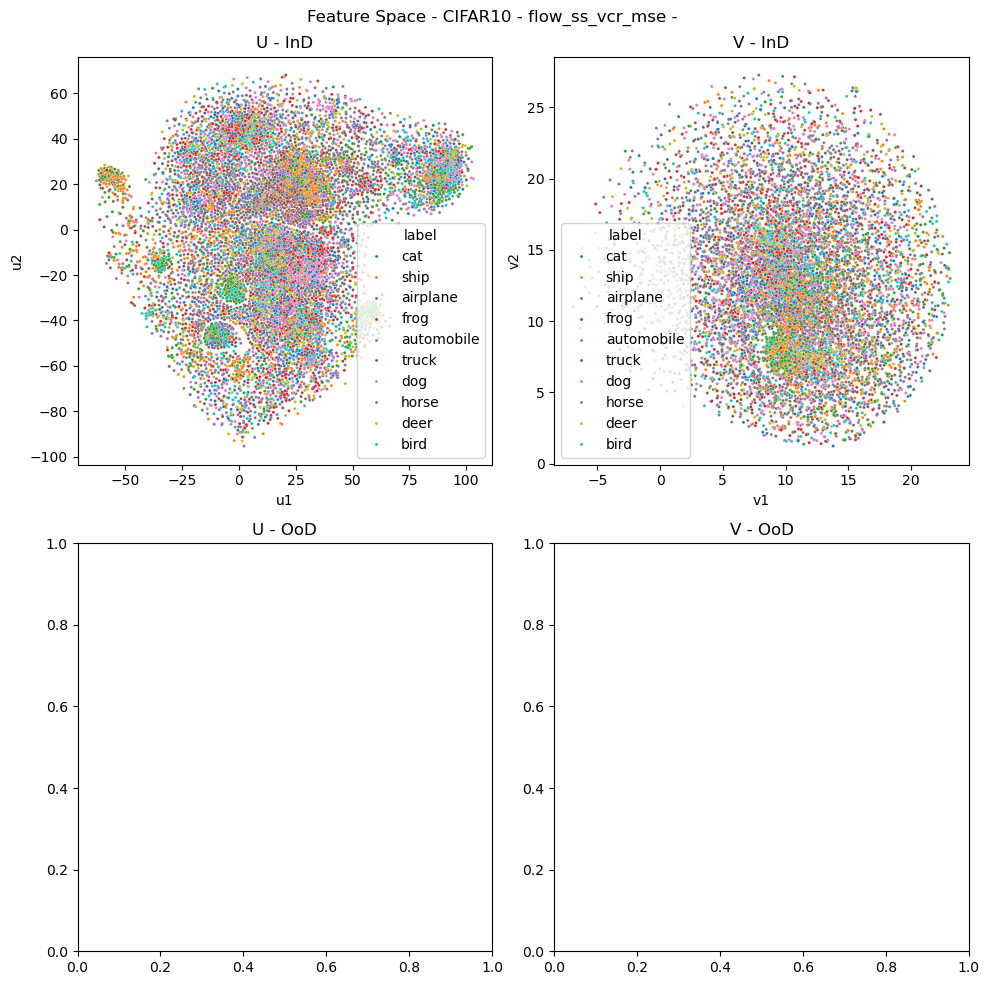

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:00<00:02,  1.34it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:01<00:01,  1.33it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:02<00:00,  1.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.29it/s]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:03<00:09,  3.17s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:06<00:06,  3.17s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:09<00:03,  3.19s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.21s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.20s/it]

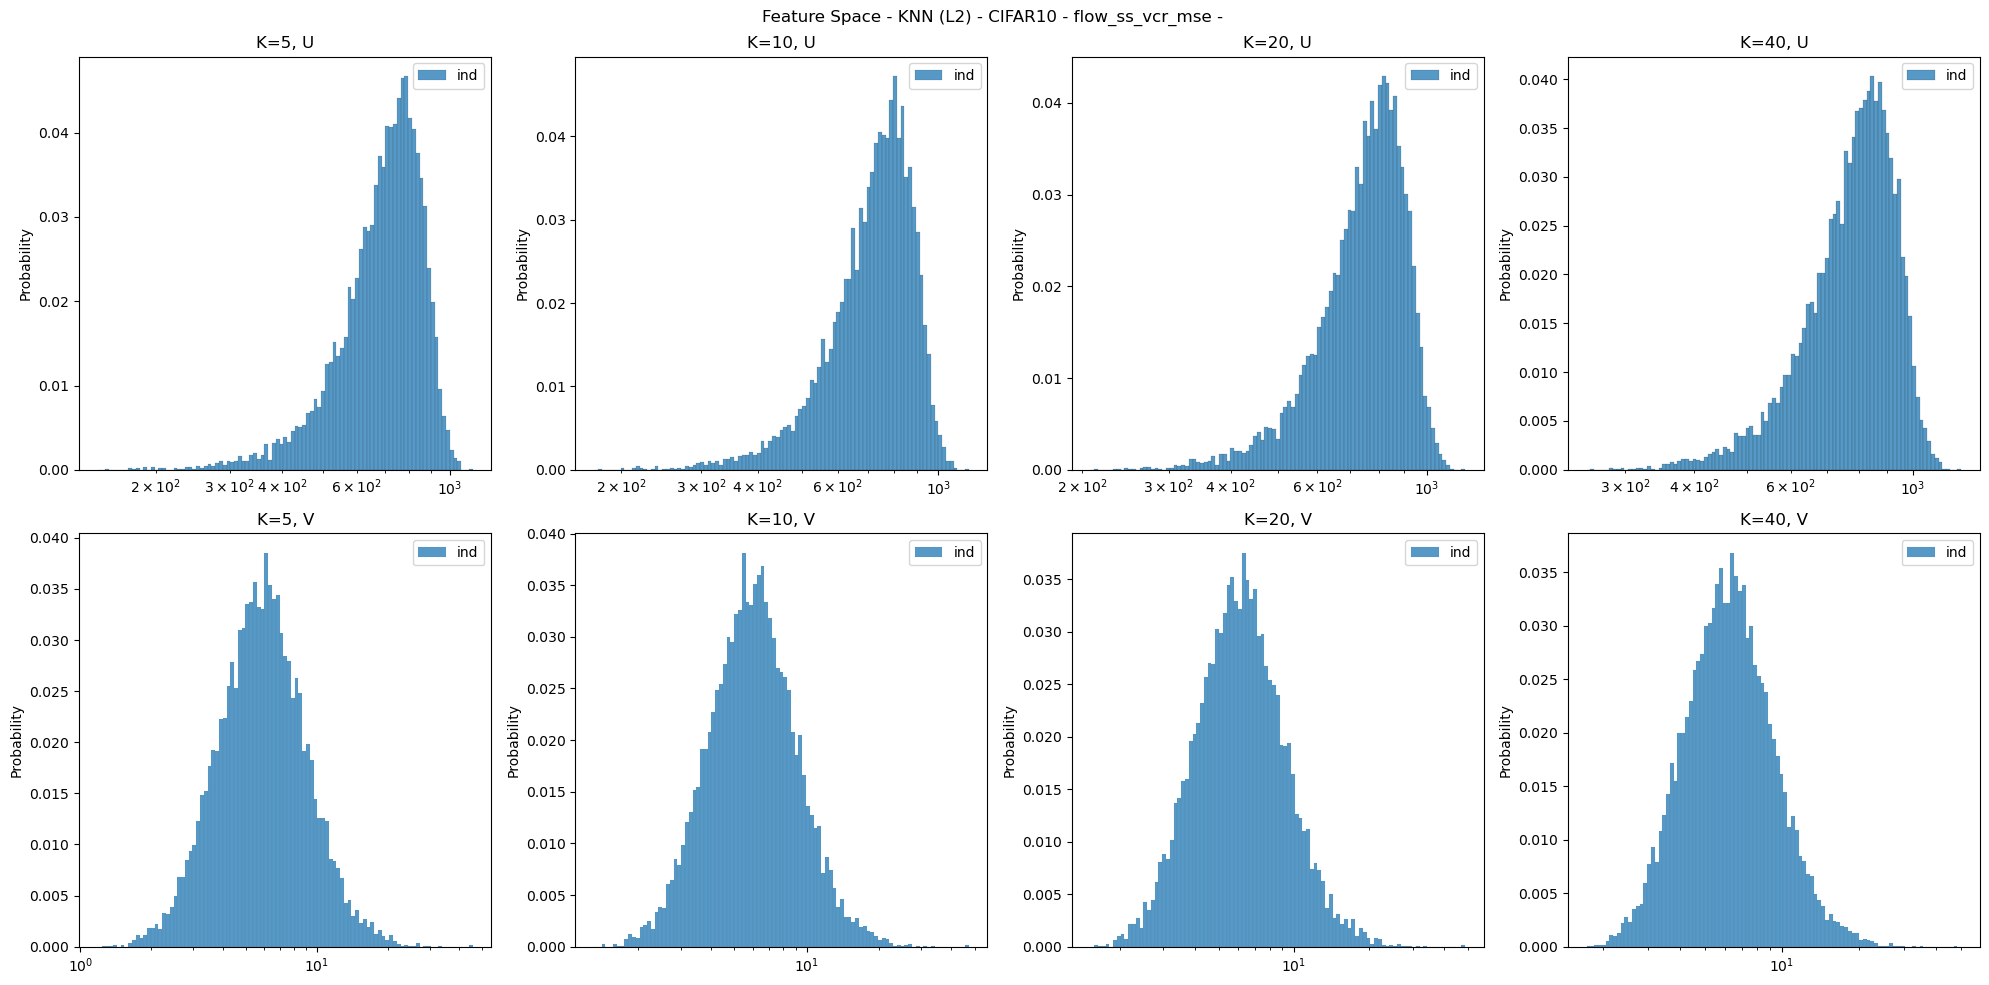

In [13]:
# plot knn to val data in feature space (L2)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:00<00:02,  1.12it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:01<00:01,  1.24it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:02<00:00,  1.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]

  0%|                                                                                                                                          | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████▌                                                                                                 | 1/4 [00:03<00:09,  3.14s/it]

 50%|█████████████████████████████████████████████████████████████████                                                                 | 2/4 [00:06<00:06,  3.14s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 3/4 [00:09<00:03,  3.16s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.19s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.17s/it]

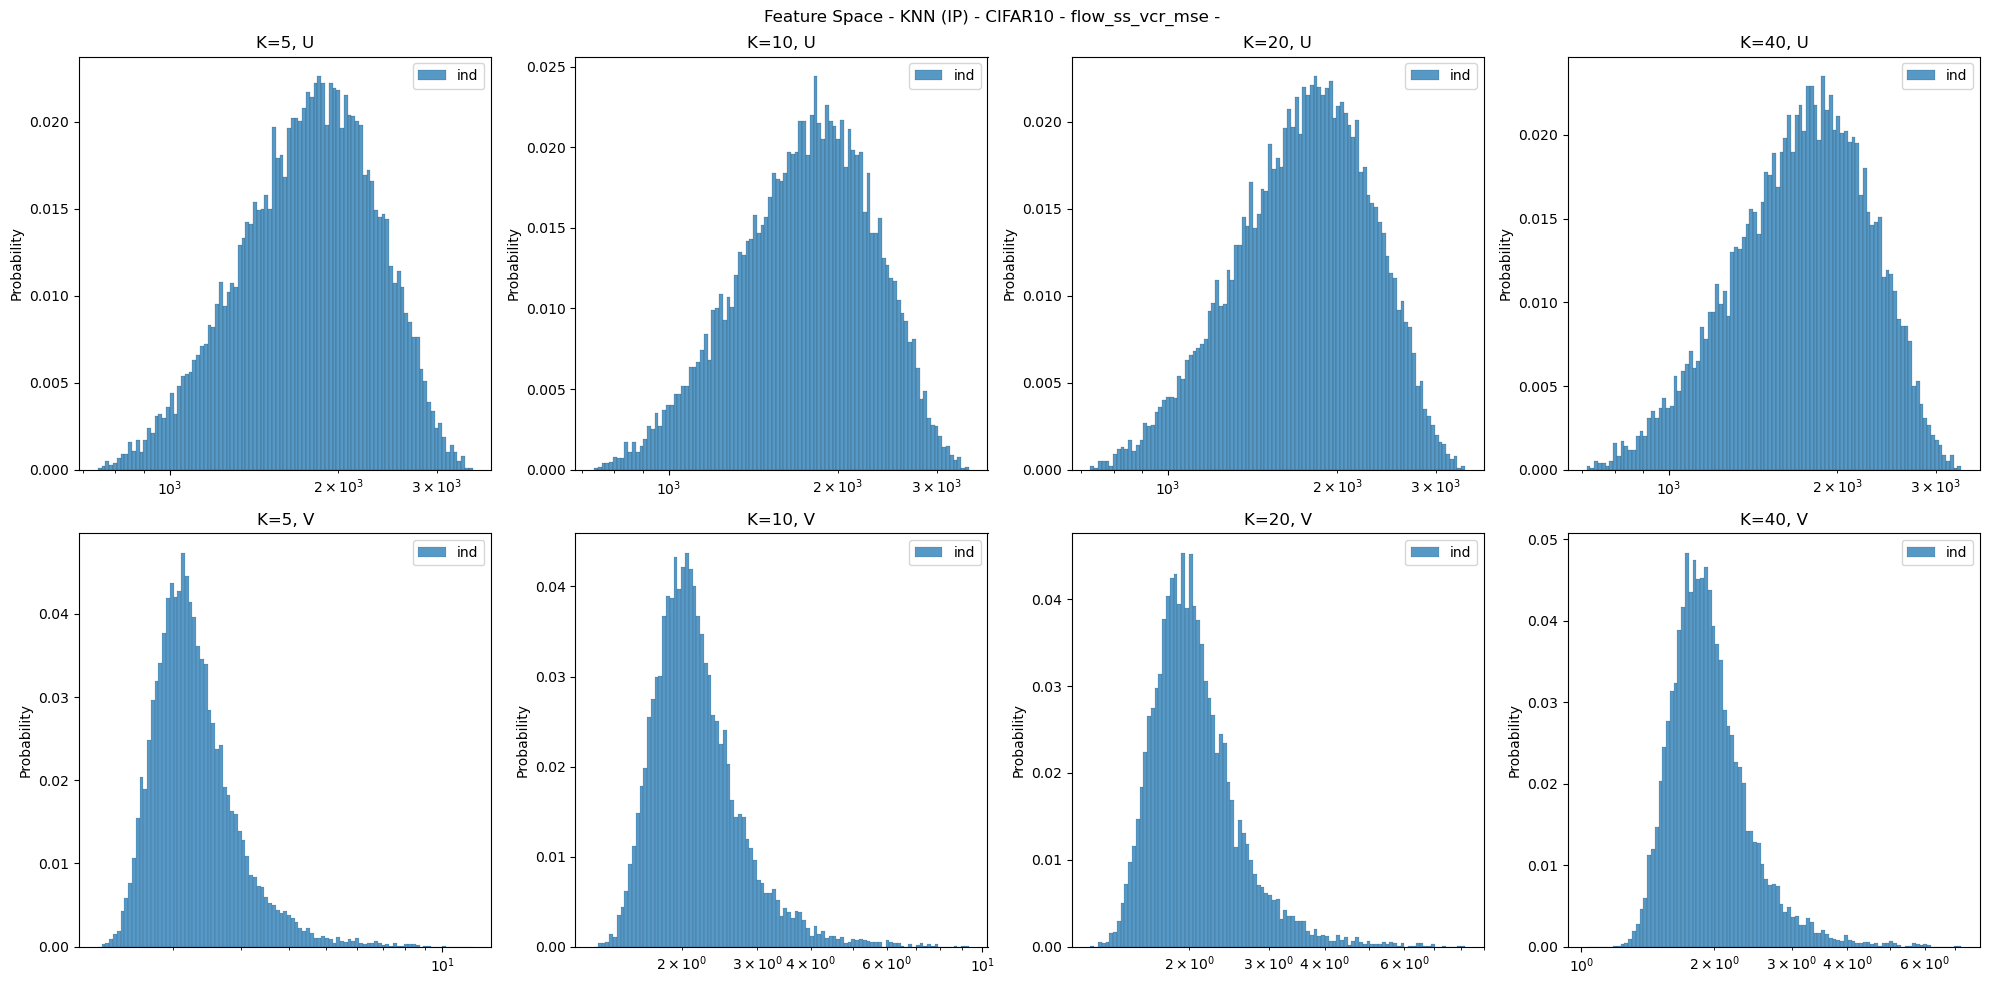

In [14]:
# plot knn to val data in feature space (IP)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

42.486088 6.1042385 2.526587 0.5318202
42.428787 6.1795287 2.5167582 0.53264475
42.62697 6.1335707 2.5250363 0.53116894
59.5305 2.7812562 45.830917 0.7645371


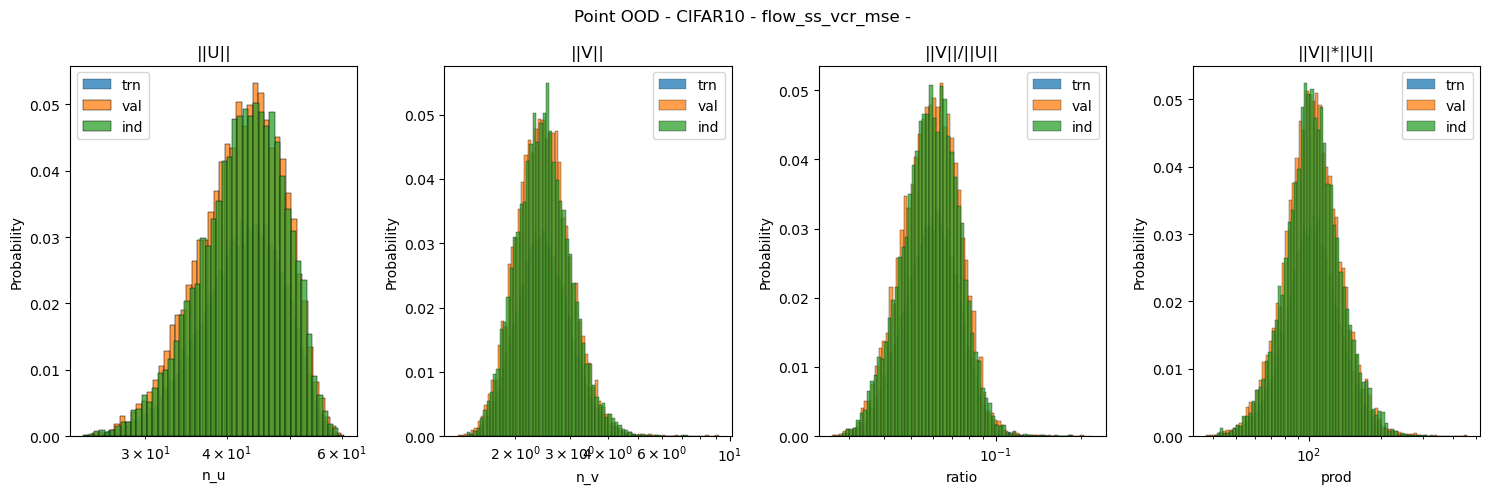

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


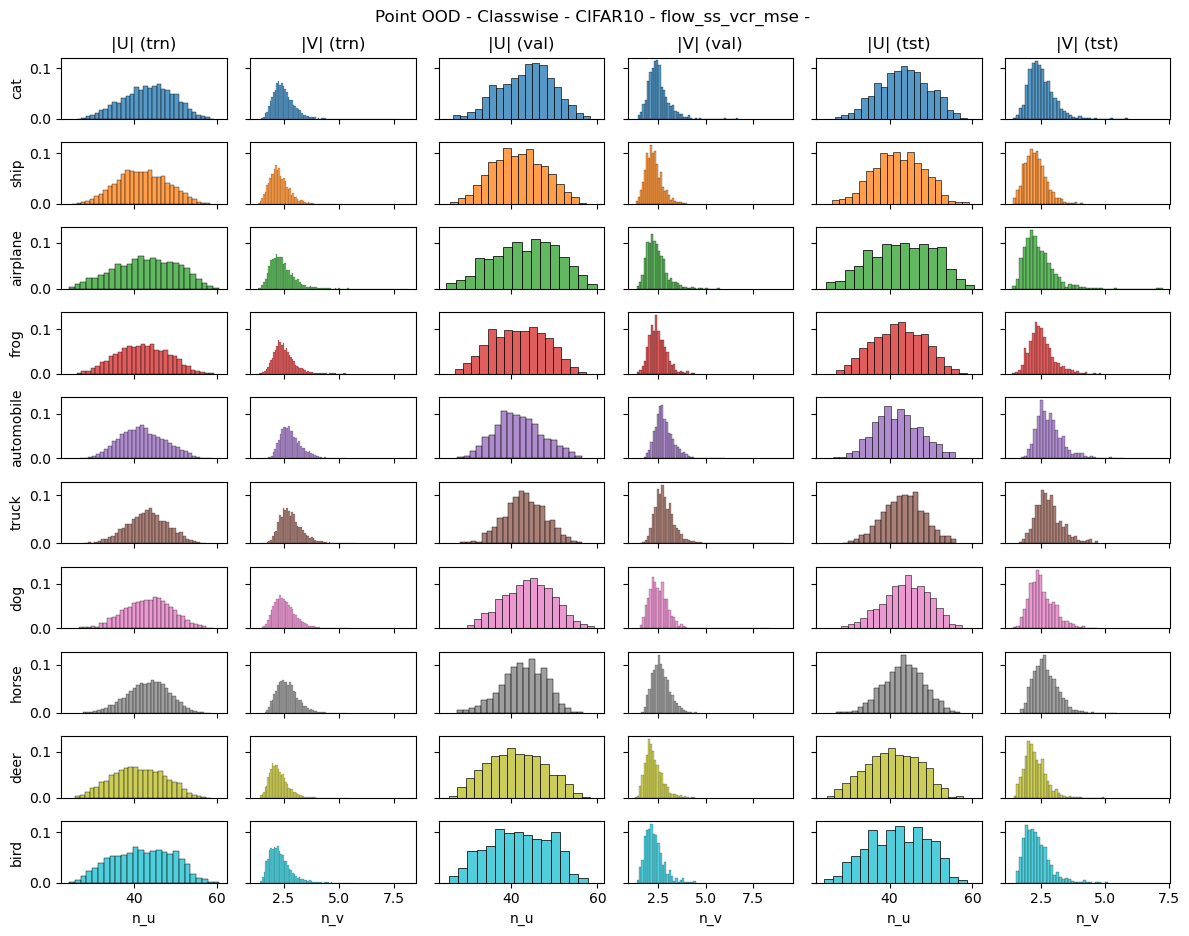

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

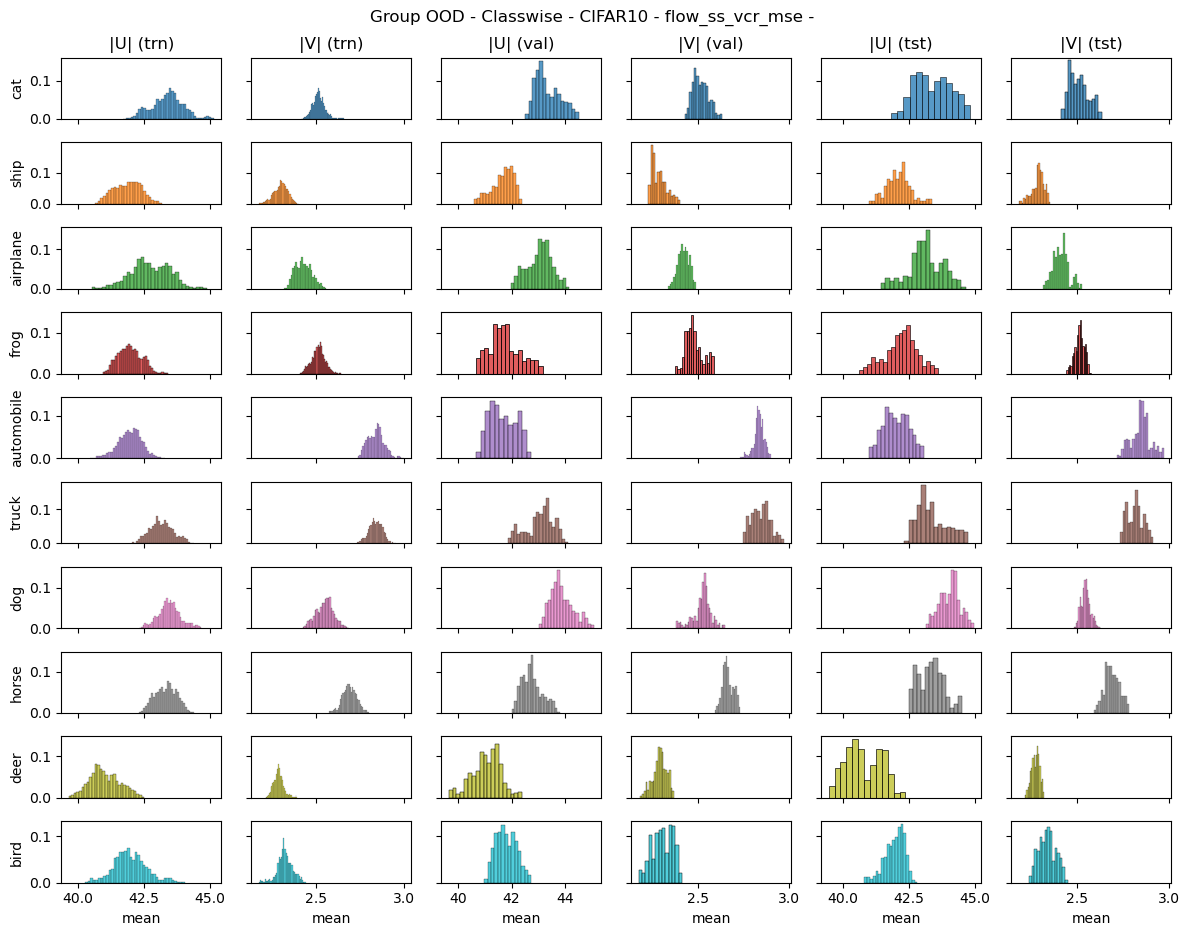

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

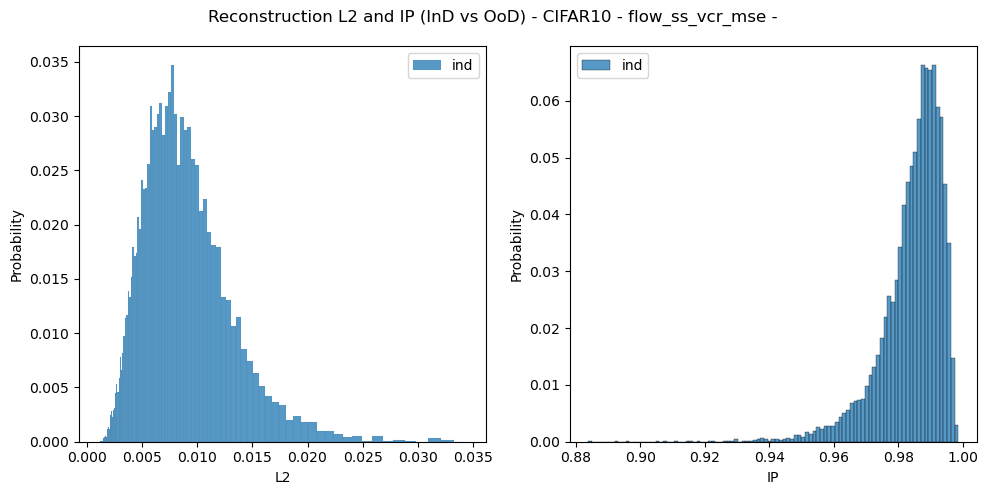

In [20]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
# store
_df = pd.DataFrame(dict(target=ind_tgt, rcn_l2=ind_rcn_l2, rcn_ip=ind_rcn_ip, source="ind"))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(target=ood_tgt, rcn_l2=ood_rcn_l2, rcn_ip=ood_rcn_ip, source="ood"))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ood", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ood", stat="probability", bins=bins_rcn_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("L2")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()